# Polynomial regression

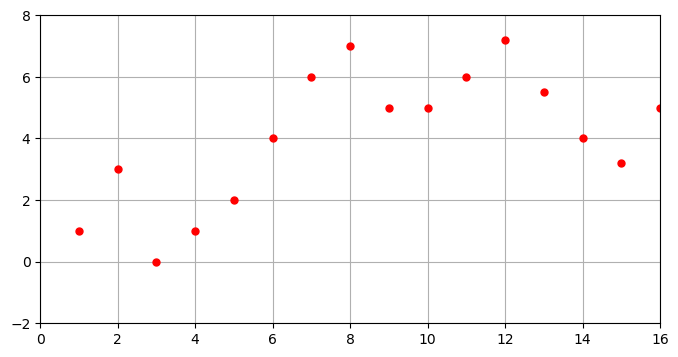

In [1]:
# define (x,y) coordinates of the points
x = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
y = [ 1, 3, 0, 1, 2, 4, 6, 7, 5, 5, 6, 7.2, 5.5,  4, 3.2, 5]

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
axis([0,16,-2,8])
grid("True")

In [4]:
# order of polynomial to use
k = 2

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

In [5]:
# NOTE: must have either Gurobi or Mosek installed!

# Solve the LEAST SQUARES polynomial fit

using JuMP, Gurobi, Mosek

#m = Model(solver=MosekSolver(LOG=0))
m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
#m = Model(solver=GurobiSolver(OutputFlag=0,NumericFocus=3,BarHomogeneous=1))

@variable(m, u[1:k+1])
@objective(m, Min, 1/1000*sum( (y - A*u).^2 ) )

status = solve(m)
uopt = getvalue(u)
println(status)
println(getobjectivevalue(m))
println(uopt)

Academic license - for non-commercial use only
Optimal
0.027563223039215157
[-0.0567402, 1.24179, -1.19375]


In [7]:
# NOTE: must have either Gurobi or Mosek installed!

# Solve the L_1 NORM polynomial fit. 
# Note: We MUST use an LP solver for this! 
# When using the L_1 criterion, there is no equivalent of the normal equations or the backslash command.

using JuMP, Gurobi, Mosek

m = Model(solver=MosekSolver(LOG=0))
m = Model(solver=GurobiSolver(OutputFlag=0,BarHomogeneous=1))
#m = Model(solver=GurobiSolver(OutputFlag=0,NumericFocus=3,BarHomogeneous=1))

@variable(m, u[1:k+1])
@variable(m, t[1:n] >= 0)
@constraint(m, y-A*u .<= t)
@constraint(m, A*u-y .<= t)
@objective(m, Min, 1/1000*sum(t))

status = solve(m)
uopt_l1 = getvalue(u)
println(status)
println(getobjectivevalue(m))
println(uopt_l1)

Optimal
0.01716666678036434
[-0.0333333, 0.833333, 0.2]


In [14]:
# Compute the LEAST SQUARES fit directly from normal equations

uopt2=inv(A'*A)*(A'*y)
println(uopt2)
residual2=1/1000*sum((y-A*uopt2).^2)

[-0.0567402, 1.24179, -1.19375]


0.027563223039215688

In [54]:
# Compute the LEAST SQUARES fit from the backslash command

uopt3=A\y

8-element Array{Float64,1}:
   5.63576e-5
  -0.00336026
   0.0805037 
  -0.988186  
   6.54486   
 -22.5034    
  35.6905    
 -17.7231    

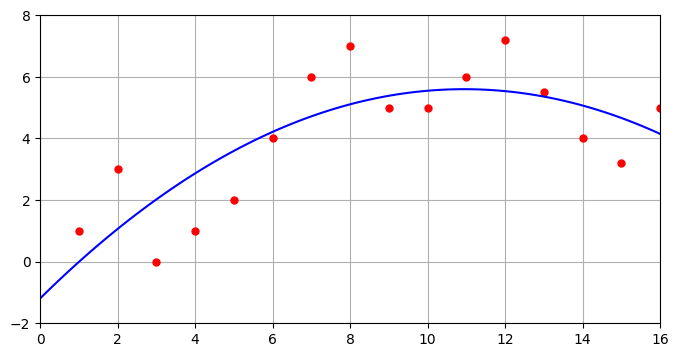

In [24]:
using PyPlot
npts = 100
xfine = linspace(0,16,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
axis([0,16,-2,8])
grid()

In [62]:
# NOTE: problem can be solved using ECOS or SCS if written as an "SOCP" --- more on this later!
# Here is a working example:

using JuMP, ECOS, SCS

#m = Model(solver=ECOSSolver(verbose=false))
m = Model(solver=SCSSolver(verbose=false))

@variable(m, u[1:k+1])
@variable(m, t)
@constraint(m, norm(y - A*u) <= t)
@objective(m, Min, t)

status = solve(m)
uopt = getvalue(u)
println(status)
println(uopt)

UnknownError
[5.64375e-5, -0.00336508, 0.0806203, -0.989636, 6.55466, -22.5384, 35.7491, -17.7564]
